# **FedArtML**

FedArtML là một công cụ cho phép tạo ra các bộ dữ liệu non-IID (Independent and Identically Distributed) datasets từ một bộ dữ liệu tập chung (Centralized) một cách có hệ thống và kiểm soát nhằm phục vụ cho việc nghiên cứu

File 2 cung cấp cách để chia bộ dữ liệu tập chung thành các bộ dữ liệu con để phục vụ cho việc huấn luyện mô hình Federated Learning

Dữ liệu được FedArtML chia sử dụng class `SplitAsFederatedData`, ngoài ra mô hình FL sẽ được huấn luyện sử dụng framework Flower.

## Tải công cụ

In [1]:
!pip install fedartml
!pip install -q flwr[simulation]

## Import các thư viện cần thiết

In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from io import BytesIO
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

import time
import pickle

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

from sklearn.impute import SimpleImputer

import plotly.graph_objects as go


# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

In [3]:
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

## Khởi tạo các tham số cần thiết

- **local_nodes_glob**: Xác định số lượng khách hàng mong muốn (nút cục bộ) mà dữ liệu tập trung sẽ được chia thành. Trong trường hợp này, chúng ta đặt nó là 2.

- **Percent_noniid**: Sử dụng phương pháp "Percentage of non-IID-ness-based", chúng ta cần xác định Percent_noniid, sẽ xác định mức độ không đồng nhất của phân phối của khách hàng (non-IID-ness). Trong trường hợp này, chúng ta đặt nó là 50. Những tham số này có thể được thay đổi nếu muốn làm quen với cách sử dụng của chúng.

In [28]:
# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Define number of local nodes to be used
local_nodes_glob = 10

# Define percentage of noniid to be used
Percent_noniid = 80

## Cài đặt các hàm

In [5]:
# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    logits = model.predict(X_test, batch_size=32, verbose=1, callbacks=[GarbageCollectorCallback()])
    y_pred = tf.argmax(logits, axis=1)
    loss = cce(Y_test, logits).numpy()
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

def get_model():
    """Constructs a simple model architecture suitable for MNIST."""
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')

        ]
    )
    model.compile("adam", "sparse_categorical_crossentropy", metrics=SparseCategoricalAccuracy())
    return model

# Define local training/evaluation function
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs_client) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.epochs_client = epochs_client

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, validation_split=0.1, epochs=self.epochs_client, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}


def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

## Load và xử lý dữ liệu

Bộ dữ liệu được sử dụng trong ví dụ sẽ là bộ dữ liệu MNIST

In [34]:
from tensorflow.keras.datasets import mnist
# Define random state for reproducibility
random_state = 0

# Tải dữ liệu MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Chuẩn hóa dữ liệu và chuyển định dạng labels sang one-hot encoding
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

# Instantiate a SplitAsFederatedData object
my_federater = SplitAsFederatedData(random_state = random_state)

# Get federated dataset from centralized dataset
clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(image_list = train_images, label_list = train_labels,
                                                             num_clients = local_nodes_glob, prefix_cli='Local_node', method = "percent_noniid", percent_noniid = 5)

clients_glob = clients_glob_dic['with_class_completion']
list_ids_sampled = list_ids_sampled_dic['with_class_completion']

list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)

Trong đoạn code trên, lớp SplitAsFederatedData được khởi tạo bằng cách sử dụng random_state để có thể tái tạo lại các kết quả.

Sau đó, hàm .create_clients thực hiện federated của dữ liệu tập trung bằng cách lấy các đặc trưng và nhãn, xác định số lượng khách hàng mong muốn và đặt tỷ lệ không đồng nhất.

Kết quả của .create_clients bao gồm:
- clients_glob_dic: Chứa các đặc trưng (hình ảnh) và nhãn cho mỗi client sau khi tạo dữ liệu liên đoàn. Bao gồm các trường hợp "with_class_completion" và "without_class_completion".
- list_ids_sampled_dic: Index của các ví dụ (phân vùng) được lấy cho mỗi client.
- miss_class_per_node: Số lượng lớp bị thiếu cho mỗi nút cục bộ khi tạo bộ dữ liệu liên đoàn.
-distances: Các khoảng cách được tính toán trong quá trình đo lường sự không đồng nhất (non-IID-ness) của phân phối nhãn giữa các khách hàng. Bao gồm các trường hợp "with_class_completion" và "without_class_completion".

Lưu ý: Khi tạo dữ liệu federated và đặt phân phối không đồng nhất, có khả năng cao rằng các client chỉ chứa các ví dụ từ một lớp. Khi đó, hai trường hợp được trả về làm đầu ra cho fed_data và distances:
- "with_class_completion": Trong trường hợp này, các client được hoàn thiện bằng một ví dụ (ngẫu nhiên) của mỗi lớp bị thiếu cho mỗi khách hàng để có tất cả các lớp nhãn.
- "without_class_completion": Trong trường hợp này, các khách hàng KHÔNG được hoàn thiện bằng một ví dụ (ngẫu nhiên) của mỗi lớp bị thiếu. Do đó, việc tổng hợp số lượng ví dụ của mỗi khách hàng dẫn đến cùng một số lượng ví dụ tổng cộng

Ngoài ra, hàm from_FedArtML_to_Flower_format được sử dụng để chuyển đổi kết quả của hàm .create_clients thành một danh sách (danh sách các tensor/numpy arrays) có thể dễ dàng được cắm vào framework Flower.

## Kiểm tra các bộ dữ liệu

Client1 shape: (5930, 2)
Client2 shape: (6025, 2)
Client3 shape: (5995, 2)
Client4 shape: (6011, 2)
Client5 shape: (6123, 2)
Client6 shape: (6084, 2)
Client7 shape: (6008, 2)
Client8 shape: (5959, 2)
Client9 shape: (5916, 2)
Client10 shape: (5949, 2)


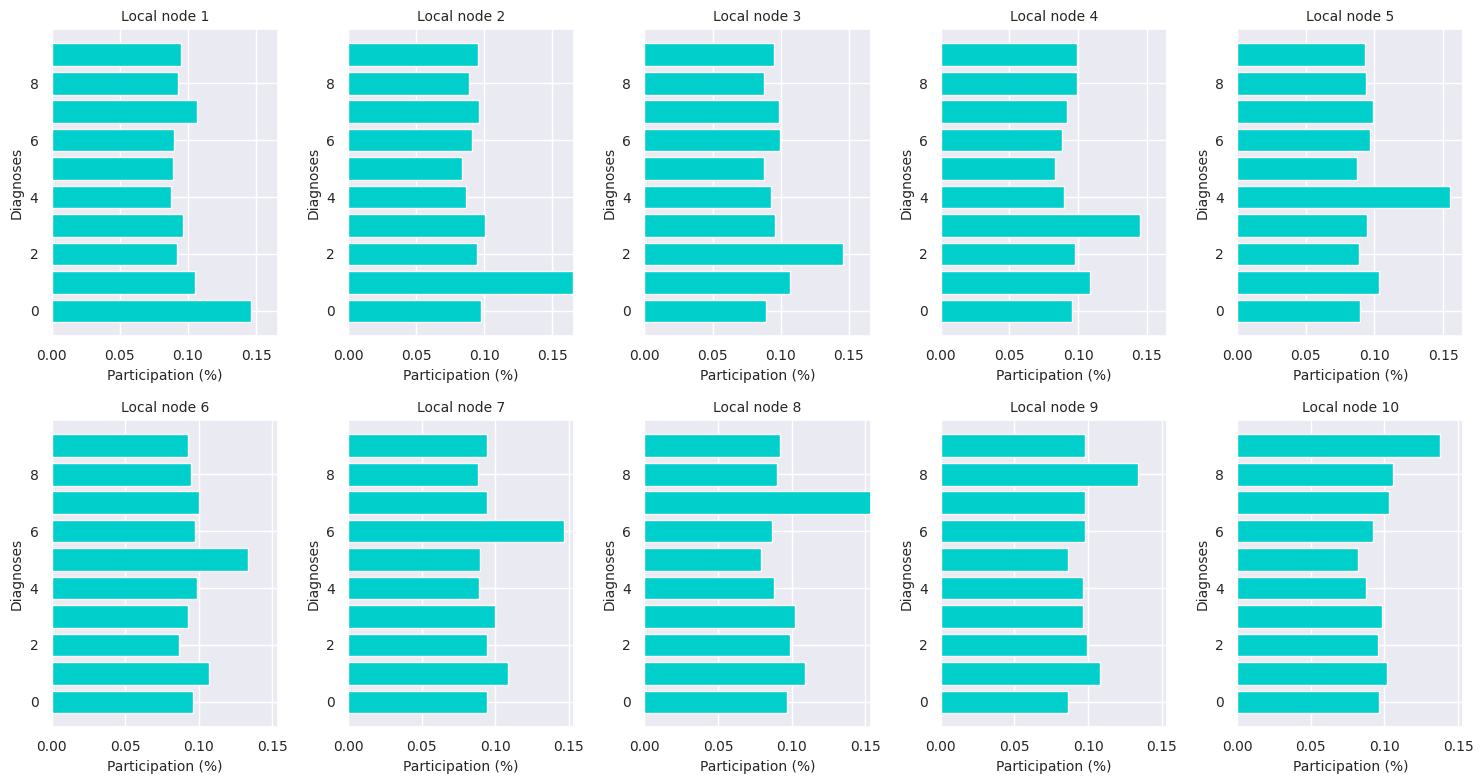

In [35]:
# Define dimensions for plot (2 rows, 5 columns)
f, axs = plt.subplots(2, 5, figsize=(15, 8))

# Initialize counter
cont = 0

max_xlab = 0.4 + 0.02
fl_append_labels = []

# Loop over the clients
for key, value in clients_glob.items():
    # Extract the labels
    labels_check = []
    for i in range(len(value)):
        val = value[i][1]
        labels_check.append(val)

    fl_append_labels = fl_append_labels + list(labels_check[:len(labels_check) - miss_class_per_node[cont]])
    labels_check = pd.DataFrame(labels_check, columns=["label"]).reset_index()

    # Get the number of diagnoses per diagnose
    group = labels_check.groupby(['label']).count().reset_index().sort_values(by=['label'], ascending=True)
    group['particip'] = group['index'].values / sum(group['index'].values)
    group.sort_values(by=['label'], ascending=False, inplace=True)

    print("Client" + str(cont + 1) + " shape:", labels_check[:len(labels_check) - miss_class_per_node[cont]].shape)

    # Plot each client barplot
    max_group = max(group['particip'])
    max_xlab = np.min([max_xlab, max_group])

    # Calculate the position in the subplot grid
    row_position = cont // 5
    col_position = cont % 5

    # Use axs[row_position, col_position] for subplot
    axs[row_position, col_position].barh(group.label, group['particip'], alpha=1, color=colors[0])
    axs[row_position, col_position].set_xlabel('Participation (%)', fontsize=10)
    axs[row_position, col_position].set_ylabel('Diagnoses', fontsize=10)
    axs[row_position, col_position].set_title(key.replace("_", " "), fontsize=10)
    axs[row_position, col_position].tick_params(axis='both', which='both', labelsize=10)
    axs[row_position, col_position].set_xlim(left=0, right=max_xlab + 0.02)

    # Increase counter
    cont += 1

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

Công cụ cũng hỗ trợ tính các khoảng cách về phân phối giữa các bộ dữ liệu.

In [31]:
# Calculate distances
JSD_glob = distances['without_class_completion']['jensen-shannon']
print("Jensen-Shannon distance:", JSD_glob)
HD_glob = distances['without_class_completion']['hellinger']
print("Hellinger distance:", HD_glob)
EMD_glob = distances['without_class_completion']['earth-movers']
print("Earth Mover’s distance:", EMD_glob)

Jensen-Shannon distance: 0.7899026092594189
Hellinger distance: 0.7645881074749187
Earth Mover’s distance: 0.050265812701560636


## Huấn luyện

In [9]:
# The `evaluate` function will be by Flower called after every round
def evaluate_DNN_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = get_model()
    net.set_weights(parameters) # Update model with the latest parameters
    loss, accuracy, precision, recall, f1score  = test_model(net, test_images, test_labels)
    print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} / f1score {f1score} @@@@@@")
    return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

In [32]:
# Define number of epochs per local node
epochs = 1

# Define number of communication rounds
comms_round = 10


# Define dunction to pass to each local node (client)
def client_fn(cid: str) -> fl.client.Client:
    # Define model
    model = get_model()

    # Load data partition of each client ID (cid)
    x_train_cid = np.array(list_x_train[int(cid)],dtype=float)
    y_train_cid = np.array(list_y_train[int(cid)],dtype=float)

    # Define test data (taken from the centralized data to compare performance of CL and FL)
    x_test_cid = np.array(test_images)
    y_test_cid = np.array(test_labels)

    # Create and return client
    return FlowerClient(model, x_train_cid, y_train_cid, x_test_cid, y_test_cid, epochs)

# Create Federated strategy
strategy=fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=local_nodes_glob,  # Never sample less than 2 clients for training
        min_evaluate_clients=local_nodes_glob//2,  # Never sample less than 1 client for evaluation
        min_available_clients=local_nodes_glob,  # Wait until all clients are available
        evaluate_fn=evaluate_DNN_CL
)

start_time = time.time()
# Start simulation (training FL)
commun_metrics_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=local_nodes_glob,
    config=fl.server.ServerConfig(num_rounds=comms_round),
    strategy=strategy,
)

# Get total training time
training_time = time.time() - start_time

# Unmask metrics
global_acc_test = retrieve_global_metrics(commun_metrics_history,"centralized","accuracy",True)

global_pre_test = retrieve_global_metrics(commun_metrics_history,"centralized","precision",True)

global_rec_test = retrieve_global_metrics(commun_metrics_history,"centralized","recall",True)

global_f1s_test = retrieve_global_metrics(commun_metrics_history,"centralized","f1score",True)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")
print('Test: commun_round: {} | global_acc: {:} | global_pre: {} | global_rec: {} | global_f1s: {}'.format(comms_round, global_acc_test, global_pre_test, global_rec_test, global_f1s_test))
print("Training time: %s seconds" % (training_time))

INFO flwr 2024-01-09 21:02:47,042 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-01-09 21:03:01,346	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-09 21:03:04,917 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3843072000.0, 'memory': 7686144000.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3843072000.0, 'memory': 7686144000.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO flwr 2024-01-09 21:03:04,926 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-01-09 2

313/313 [==============================] - 2s 6ms/step


INFO flwr 2024-01-09 21:03:18,654 | server.py:94 | initial parameters (loss, other metrics): 2.319451, {'accuracy': 0.0885, 'precision': 0.4277408308480493, 'recall': 0.0885, 'f1score': 0.13708963487106368}
INFO:flwr:initial parameters (loss, other metrics): 2.319451, {'accuracy': 0.0885, 'precision': 0.4277408308480493, 'recall': 0.0885, 'f1score': 0.13708963487106368}
INFO flwr 2024-01-09 21:03:18,661 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-01-09 21:03:18,666 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 10)


@@@@@@ Server-side evaluation loss 2.319451093673706 / accuracy 0.0885 / f1score 0.13708963487106368 @@@@@@
(DefaultActor pid=108053) 166/166 - 6s - loss: 0.5657 - sparse_categorical_accuracy: 0.8765 - val_loss: 2.6230 - val_sparse_categorical_accuracy: 0.2352 - 6s/epoch - 38ms/step
(DefaultActor pid=108053) 167/167 - 8s - loss: 0.4040 - sparse_categorical_accuracy: 0.9084 - val_loss: 1.6827 - val_sparse_categorical_accuracy: 0.5034 - 8s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 164/164 - 6s - loss: 0.4172 - sparse_categorical_accuracy: 0.9097 - val_loss: 1.4869 - val_sparse_categorical_accuracy: 0.5780 - 6s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 167/167 - 8s - loss: 0.5141 - sparse_categorical_accuracy: 0.8900 - val_loss: 1.8196 - val_sparse_categorical_accuracy: 0.4579 - 8s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 156/156 - 6s - loss: 0.5103 - sparse_categorical_accuracy: 0.8894 - val_los

DEBUG flwr 2024-01-09 21:04:00,670 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2024-01-09 21:04:00,719 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


313/313 [==============================] - 3s 9ms/step


INFO flwr 2024-01-09 21:04:06,249 | server.py:125 | fit progress: (1, 1.8592793, {'accuracy': 0.6171, 'precision': 0.7430404421864817, 'recall': 0.6171, 'f1score': 0.6455481529187737}, 47.583145361999414)
INFO:flwr:fit progress: (1, 1.8592793, {'accuracy': 0.6171, 'precision': 0.7430404421864817, 'recall': 0.6171, 'f1score': 0.6455481529187737}, 47.583145361999414)
DEBUG flwr 2024-01-09 21:04:06,255 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 1.8592792749404907 / accuracy 0.6171 / f1score 0.6455481529187737 @@@@@@
(DefaultActor pid=108052) 313/313 - 3s - loss: 1.8593 - sparse_categorical_accuracy: 0.6171 - 3s/epoch - 10ms/step
(DefaultActor pid=108052) 170/170 - 6s - loss: 0.4578 - sparse_categorical_accuracy: 0.8977 - val_loss: 1.9941 - val_sparse_categorical_accuracy: 0.4702 - 6s/epoch - 35ms/step


DEBUG flwr 2024-01-09 21:04:18,855 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-01-09 21:04:18,859 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-01-09 21:04:18,863 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108052) 313/313 - 4s - loss: 1.8593 - sparse_categorical_accuracy: 0.6171 - 4s/epoch - 12ms/step [repeated 4x across cluster]
(DefaultActor pid=108052) 156/156 - 6s - loss: 0.3164 - sparse_categorical_accuracy: 0.9261 - val_loss: 0.5894 - val_sparse_categorical_accuracy: 0.8054 - 6s/epoch - 37ms/step
(DefaultActor pid=108052) 167/167 - 8s - loss: 0.2778 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.8211 - val_sparse_categorical_accuracy: 0.7256 - 8s/epoch - 48ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 173/173 - 7s - loss: 0.2443 - sparse_categorical_accuracy: 0.9377 - val_loss: 0.7510 - val_sparse_categorical_accuracy: 0.7410 - 7s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 167/167 - 7s - loss: 0.2044 - sparse_categorical_accuracy: 0.9445 - val_loss: 0.8251 - val_sparse_categorical_accuracy: 0.7191 - 7s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 164/164 - 6s - loss: 0.2578 - sparse_ca

DEBUG flwr 2024-01-09 21:04:56,866 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


313/313 [==============================] - 2s 6ms/step


INFO flwr 2024-01-09 21:04:59,771 | server.py:125 | fit progress: (2, 0.61688536, {'accuracy': 0.8174, 'precision': 0.8440480379437891, 'recall': 0.8174, 'f1score': 0.82330436096131}, 101.10497878000024)
INFO:flwr:fit progress: (2, 0.61688536, {'accuracy': 0.8174, 'precision': 0.8440480379437891, 'recall': 0.8174, 'f1score': 0.82330436096131}, 101.10497878000024)
DEBUG flwr 2024-01-09 21:04:59,776 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 0.6168853640556335 / accuracy 0.8174 / f1score 0.82330436096131 @@@@@@
(DefaultActor pid=108053) 313/313 - 5s - loss: 0.6169 - sparse_categorical_accuracy: 0.8174 - 5s/epoch - 15ms/step
(DefaultActor pid=108052) 189/189 - 7s - loss: 0.1686 - sparse_categorical_accuracy: 0.9554 - val_loss: 0.8954 - val_sparse_categorical_accuracy: 0.7030 - 7s/epoch - 37ms/step
(DefaultActor pid=108053) 313/313 - 5s - loss: 0.6169 - sparse_categorical_accuracy: 0.8174 - 5s/epoch - 15ms/step [repeated 2x across cluster]


DEBUG flwr 2024-01-09 21:05:13,202 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-01-09 21:05:13,207 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108052) 167/167 - 7s - loss: 0.1151 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.5687 - val_sparse_categorical_accuracy: 0.7980 - 7s/epoch - 42ms/step
(DefaultActor pid=108053) 313/313 - 2s - loss: 0.6169 - sparse_categorical_accuracy: 0.8174 - 2s/epoch - 6ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 164/164 - 9s - loss: 0.1282 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.5654 - val_sparse_categorical_accuracy: 0.8045 - 9s/epoch - 55ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 166/166 - 11s - loss: 0.1765 - sparse_categorical_accuracy: 0.9473 - val_loss: 0.7683 - val_sparse_categorical_accuracy: 0.7208 - 11s/epoch - 63ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 156/156 - 6s - loss: 0.1609 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.2881 - val_sparse_categorical_accuracy: 0.9135 - 6s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 172/172 - 8s - loss: 0.1389 - sparse_c

DEBUG flwr 2024-01-09 21:05:57,109 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


313/313 [==============================] - 2s 7ms/step


INFO flwr 2024-01-09 21:05:59,712 | server.py:125 | fit progress: (3, 0.32247213, {'accuracy': 0.9055, 'precision': 0.9076794999145797, 'recall': 0.9055, 'f1score': 0.9061046347226948}, 161.0456848169997)
INFO:flwr:fit progress: (3, 0.32247213, {'accuracy': 0.9055, 'precision': 0.9076794999145797, 'recall': 0.9055, 'f1score': 0.9061046347226948}, 161.0456848169997)
DEBUG flwr 2024-01-09 21:05:59,718 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 0.32247212529182434 / accuracy 0.9055 / f1score 0.9061046347226948 @@@@@@
(DefaultActor pid=108053) 313/313 - 3s - loss: 0.3225 - sparse_categorical_accuracy: 0.9055 - 3s/epoch - 11ms/step
(DefaultActor pid=108053) 167/167 - 8s - loss: 0.0933 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.5804 - val_sparse_categorical_accuracy: 0.8206 - 8s/epoch - 46ms/step


DEBUG flwr 2024-01-09 21:06:11,866 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-01-09 21:06:11,870 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108053) 313/313 - 4s - loss: 0.3225 - sparse_categorical_accuracy: 0.9055 - 4s/epoch - 12ms/step [repeated 4x across cluster]
(DefaultActor pid=108053) 166/166 - 7s - loss: 0.1332 - sparse_categorical_accuracy: 0.9574 - val_loss: 0.4438 - val_sparse_categorical_accuracy: 0.8443 - 7s/epoch - 40ms/step
(DefaultActor pid=108053) 167/167 - 7s - loss: 0.0824 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.6498 - val_sparse_categorical_accuracy: 0.7727 - 7s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 172/172 - 7s - loss: 0.0946 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.5720 - val_sparse_categorical_accuracy: 0.7918 - 7s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 156/156 - 7s - loss: 0.1069 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.4912 - val_sparse_categorical_accuracy: 0.8342 - 7s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 167/167 - 7s - loss: 0.0644 - sparse_ca

DEBUG flwr 2024-01-09 21:06:50,030 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


313/313 [==============================] - 2s 5ms/step


INFO flwr 2024-01-09 21:06:52,890 | server.py:125 | fit progress: (4, 0.21856216, {'accuracy': 0.9343, 'precision': 0.9351211277924821, 'recall': 0.9343, 'f1score': 0.9343834831245069}, 214.22405525499926)
INFO:flwr:fit progress: (4, 0.21856216, {'accuracy': 0.9343, 'precision': 0.9351211277924821, 'recall': 0.9343, 'f1score': 0.9343834831245069}, 214.22405525499926)
DEBUG flwr 2024-01-09 21:06:52,896 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 0.21856215596199036 / accuracy 0.9343 / f1score 0.9343834831245069 @@@@@@
(DefaultActor pid=108052) 313/313 - 4s - loss: 0.2186 - sparse_categorical_accuracy: 0.9343 - 4s/epoch - 13ms/step
(DefaultActor pid=108052) 164/164 - 6s - loss: 0.0866 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.4445 - val_sparse_categorical_accuracy: 0.8439 - 6s/epoch - 36ms/step


DEBUG flwr 2024-01-09 21:07:05,709 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-01-09 21:07:05,713 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108052) 313/313 - 2s - loss: 0.2186 - sparse_categorical_accuracy: 0.9343 - 2s/epoch - 6ms/step [repeated 4x across cluster]
(DefaultActor pid=108052) 156/156 - 7s - loss: 0.0824 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.2130 - val_sparse_categorical_accuracy: 0.9477 - 7s/epoch - 43ms/step
(DefaultActor pid=108052) 170/170 - 7s - loss: 0.0876 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.6254 - val_sparse_categorical_accuracy: 0.7947 - 7s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 166/166 - 6s - loss: 0.0930 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.1935 - val_sparse_categorical_accuracy: 0.9391 - 6s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 172/172 - 7s - loss: 0.0703 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.2646 - val_sparse_categorical_accuracy: 0.9230 - 7s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 189/189 - 6s - loss: 0.0504 - sparse_cat

DEBUG flwr 2024-01-09 21:07:43,394 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


313/313 [==============================] - 3s 9ms/step


INFO flwr 2024-01-09 21:07:46,852 | server.py:125 | fit progress: (5, 0.17086816, {'accuracy': 0.9483, 'precision': 0.949330853049018, 'recall': 0.9483, 'f1score': 0.9485192431813532}, 268.1859937490008)
INFO:flwr:fit progress: (5, 0.17086816, {'accuracy': 0.9483, 'precision': 0.949330853049018, 'recall': 0.9483, 'f1score': 0.9485192431813532}, 268.1859937490008)
DEBUG flwr 2024-01-09 21:07:46,856 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 0.1708681583404541 / accuracy 0.9483 / f1score 0.9485192431813532 @@@@@@
(DefaultActor pid=108053) 313/313 - 3s - loss: 0.1709 - sparse_categorical_accuracy: 0.9483 - 3s/epoch - 10ms/step
(DefaultActor pid=108053) 167/167 - 6s - loss: 0.0525 - sparse_categorical_accuracy: 0.9836 - val_loss: 0.2800 - val_sparse_categorical_accuracy: 0.9086 - 6s/epoch - 35ms/step


DEBUG flwr 2024-01-09 21:07:58,243 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2024-01-09 21:07:58,246 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108053) 313/313 - 2s - loss: 0.1709 - sparse_categorical_accuracy: 0.9483 - 2s/epoch - 8ms/step [repeated 4x across cluster]
(DefaultActor pid=108053) 167/167 - 8s - loss: 0.0459 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.2760 - val_sparse_categorical_accuracy: 0.9189 - 8s/epoch - 48ms/step
(DefaultActor pid=108053) 156/156 - 6s - loss: 0.0605 - sparse_categorical_accuracy: 0.9814 - val_loss: 0.1979 - val_sparse_categorical_accuracy: 0.9297 - 6s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 170/170 - 8s - loss: 0.0748 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.3350 - val_sparse_categorical_accuracy: 0.8858 - 8s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 172/172 - 6s - loss: 0.0673 - sparse_categorical_accuracy: 0.9794 - val_loss: 0.2108 - val_sparse_categorical_accuracy: 0.9328 - 6s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 164/164 - 8s - loss: 0.0530 - sparse_cat

DEBUG flwr 2024-01-09 21:08:38,452 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


313/313 [==============================] - 2s 6ms/step


INFO flwr 2024-01-09 21:08:40,851 | server.py:125 | fit progress: (6, 0.1398658, {'accuracy': 0.9576, 'precision': 0.9579910047714509, 'recall': 0.9576, 'f1score': 0.9576510282685876}, 322.1847675280005)
INFO:flwr:fit progress: (6, 0.1398658, {'accuracy': 0.9576, 'precision': 0.9579910047714509, 'recall': 0.9576, 'f1score': 0.9576510282685876}, 322.1847675280005)
DEBUG flwr 2024-01-09 21:08:40,857 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 0.13986580073833466 / accuracy 0.9576 / f1score 0.9576510282685876 @@@@@@
(DefaultActor pid=108052) 313/313 - 5s - loss: 0.1399 - sparse_categorical_accuracy: 0.9576 - 5s/epoch - 16ms/step
(DefaultActor pid=108052) 167/167 - 8s - loss: 0.0546 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.2037 - val_sparse_categorical_accuracy: 0.9444 - 8s/epoch - 45ms/step
(DefaultActor pid=108052) 313/313 - 7s - loss: 0.1399 - sparse_categorical_accuracy: 0.9576 - 7s/epoch - 21ms/step [repeated 2x across cluster]


DEBUG flwr 2024-01-09 21:08:56,775 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2024-01-09 21:08:56,781 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108052) 164/164 - 6s - loss: 0.0450 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.3587 - val_sparse_categorical_accuracy: 0.8885 - 6s/epoch - 35ms/step
(DefaultActor pid=108052) 313/313 - 2s - loss: 0.1399 - sparse_categorical_accuracy: 0.9576 - 2s/epoch - 6ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 173/173 - 8s - loss: 0.0480 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.2010 - val_sparse_categorical_accuracy: 0.9365 - 8s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 167/167 - 6s - loss: 0.0404 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.3585 - val_sparse_categorical_accuracy: 0.8818 - 6s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 167/167 - 8s - loss: 0.0411 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.1871 - val_sparse_categorical_accuracy: 0.9323 - 8s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 156/156 - 6s - loss: 0.0555 - sparse_cat

DEBUG flwr 2024-01-09 21:09:33,066 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


313/313 [==============================] - 2s 5ms/step


INFO flwr 2024-01-09 21:09:35,233 | server.py:125 | fit progress: (7, 0.113334544, {'accuracy': 0.9661, 'precision': 0.9662966348014222, 'recall': 0.9661, 'f1score': 0.9661407339458857}, 376.5671930230001)
INFO:flwr:fit progress: (7, 0.113334544, {'accuracy': 0.9661, 'precision': 0.9662966348014222, 'recall': 0.9661, 'f1score': 0.9661407339458857}, 376.5671930230001)
DEBUG flwr 2024-01-09 21:09:35,238 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 0.1133345440030098 / accuracy 0.9661 / f1score 0.9661407339458857 @@@@@@
(DefaultActor pid=108053) 313/313 - 5s - loss: 0.1133 - sparse_categorical_accuracy: 0.9661 - 5s/epoch - 16ms/step
(DefaultActor pid=108053) 166/166 - 5s - loss: 0.0667 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.2571 - val_sparse_categorical_accuracy: 0.9188 - 5s/epoch - 33ms/step


DEBUG flwr 2024-01-09 21:09:48,189 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2024-01-09 21:09:48,193 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108053) 313/313 - 2s - loss: 0.1133 - sparse_categorical_accuracy: 0.9661 - 2s/epoch - 5ms/step [repeated 4x across cluster]
(DefaultActor pid=108052) 156/156 - 8s - loss: 0.0506 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.1083 - val_sparse_categorical_accuracy: 0.9622 - 8s/epoch - 50ms/step
(DefaultActor pid=108052) 167/167 - 6s - loss: 0.0424 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.2720 - val_sparse_categorical_accuracy: 0.9003 - 6s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 170/170 - 8s - loss: 0.0582 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.8924 - 8s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=108052) 164/164 - 6s - loss: 0.0340 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.2294 - val_sparse_categorical_accuracy: 0.9297 - 6s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-01-09 21:10:25,113 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


(DefaultActor pid=108052) 172/172 - 7s - loss: 0.0475 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.1368 - val_sparse_categorical_accuracy: 0.9623 - 7s/epoch - 39ms/step [repeated 2x across cluster]
313/313 [==============================] - 3s 9ms/step


INFO flwr 2024-01-09 21:10:28,405 | server.py:125 | fit progress: (8, 0.100168556, {'accuracy': 0.9684, 'precision': 0.9685775003949547, 'recall': 0.9684, 'f1score': 0.9684044384242461}, 429.73861386499993)
INFO:flwr:fit progress: (8, 0.100168556, {'accuracy': 0.9684, 'precision': 0.9685775003949547, 'recall': 0.9684, 'f1score': 0.9684044384242461}, 429.73861386499993)


@@@@@@ Server-side evaluation loss 0.10016855597496033 / accuracy 0.9684 / f1score 0.9684044384242461 @@@@@@


DEBUG flwr 2024-01-09 21:10:28,414 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 5 clients (out of 10)


(DefaultActor pid=108053) 313/313 - 3s - loss: 0.1002 - sparse_categorical_accuracy: 0.9684 - 3s/epoch - 9ms/step
(DefaultActor pid=108053) 167/167 - 7s - loss: 0.0319 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.2693 - val_sparse_categorical_accuracy: 0.9137 - 7s/epoch - 40ms/step


DEBUG flwr 2024-01-09 21:10:38,111 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2024-01-09 21:10:38,114 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108053) 313/313 - 2s - loss: 0.1002 - sparse_categorical_accuracy: 0.9684 - 2s/epoch - 6ms/step [repeated 4x across cluster]
(DefaultActor pid=108053) 167/167 - 7s - loss: 0.0387 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.2090 - val_sparse_categorical_accuracy: 0.9327 - 7s/epoch - 44ms/step
(DefaultActor pid=108052) 167/167 - 6s - loss: 0.0296 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.1947 - val_sparse_categorical_accuracy: 0.9442 - 6s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 164/164 - 8s - loss: 0.0348 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.2665 - val_sparse_categorical_accuracy: 0.9228 - 8s/epoch - 47ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 156/156 - 5s - loss: 0.0474 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0911 - val_sparse_categorical_accuracy: 0.9658 - 5s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 166/166 - 8s - loss: 0.0494 - sparse_cat

DEBUG flwr 2024-01-09 21:11:17,245 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


313/313 [==============================] - 2s 5ms/step


INFO flwr 2024-01-09 21:11:20,101 | server.py:125 | fit progress: (9, 0.088274255, {'accuracy': 0.9728, 'precision': 0.9728983456198297, 'recall': 0.9728, 'f1score': 0.9728064268932809}, 481.4346483320005)
INFO:flwr:fit progress: (9, 0.088274255, {'accuracy': 0.9728, 'precision': 0.9728983456198297, 'recall': 0.9728, 'f1score': 0.9728064268932809}, 481.4346483320005)
DEBUG flwr 2024-01-09 21:11:20,107 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 0.08827425539493561 / accuracy 0.9728 / f1score 0.9728064268932809 @@@@@@
(DefaultActor pid=108053) 313/313 - 3s - loss: 0.0883 - sparse_categorical_accuracy: 0.9728 - 3s/epoch - 9ms/step
(DefaultActor pid=108052) 189/189 - 8s - loss: 0.0312 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.2265 - val_sparse_categorical_accuracy: 0.9239 - 8s/epoch - 44ms/step
(DefaultActor pid=108053) 313/313 - 4s - loss: 0.0883 - sparse_categorical_accuracy: 0.9728 - 4s/epoch - 14ms/step [repeated 2x across cluster]


DEBUG flwr 2024-01-09 21:11:32,107 | server.py:187 | evaluate_round 9 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2024-01-09 21:11:32,110 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 10)


(DefaultActor pid=108053) 167/167 - 6s - loss: 0.0263 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.1256 - val_sparse_categorical_accuracy: 0.9729 - 6s/epoch - 39ms/step
(DefaultActor pid=108053) 313/313 - 2s - loss: 0.0883 - sparse_categorical_accuracy: 0.9728 - 2s/epoch - 7ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 170/170 - 8s - loss: 0.0530 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.2200 - val_sparse_categorical_accuracy: 0.9272 - 8s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 167/167 - 6s - loss: 0.0353 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.2046 - val_sparse_categorical_accuracy: 0.9341 - 6s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 156/156 - 8s - loss: 0.0420 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.2042 - val_sparse_categorical_accuracy: 0.9405 - 8s/epoch - 54ms/step [repeated 2x across cluster]
(DefaultActor pid=108053) 167/167 - 7s - loss: 0.0307 - sparse_cat

DEBUG flwr 2024-01-09 21:12:11,539 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


313/313 [==============================] - 2s 6ms/step


INFO flwr 2024-01-09 21:12:14,403 | server.py:125 | fit progress: (10, 0.08388153, {'accuracy': 0.9731, 'precision': 0.973236919713912, 'recall': 0.9731, 'f1score': 0.9731147236182848}, 535.7368610739995)
INFO:flwr:fit progress: (10, 0.08388153, {'accuracy': 0.9731, 'precision': 0.973236919713912, 'recall': 0.9731, 'f1score': 0.9731147236182848}, 535.7368610739995)
DEBUG flwr 2024-01-09 21:12:14,412 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 5 clients (out of 10)


@@@@@@ Server-side evaluation loss 0.08388152718544006 / accuracy 0.9731 / f1score 0.9731147236182848 @@@@@@
(DefaultActor pid=108052) 313/313 - 4s - loss: 0.0839 - sparse_categorical_accuracy: 0.9731 - 4s/epoch - 14ms/step
(DefaultActor pid=108052) 172/172 - 7s - loss: 0.0412 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.2610 - val_sparse_categorical_accuracy: 0.9197 - 7s/epoch - 39ms/step


DEBUG flwr 2024-01-09 21:12:25,859 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 5 results and 0 failures
INFO flwr 2024-01-09 21:12:25,862 | server.py:153 | FL finished in 547.1955733249997
INFO:flwr:FL finished in 547.1955733249997
INFO flwr 2024-01-09 21:12:25,865 | app.py:226 | app_fit: losses_distributed [(1, 1.8592791557312012), (2, 0.6168853640556335), (3, 0.3224721848964691), (4, 0.2185622602701187), (5, 0.1708681732416153), (6, 0.1398657262325287), (7, 0.113334521651268), (8, 0.10016847401857376), (9, 0.08827415108680725), (10, 0.08388141542673111)]
INFO:flwr:app_fit: losses_distributed [(1, 1.8592791557312012), (2, 0.6168853640556335), (3, 0.3224721848964691), (4, 0.2185622602701187), (5, 0.1708681732416153), (6, 0.1398657262325287), (7, 0.113334521651268), (8, 0.10016847401857376), (9, 0.08827415108680725), (10, 0.08388141542673111)]
INFO flwr 2024-01-09 21:12:25,868 | app.py:227 | app_fit: metrics_distributed_fit



FINAL RESULTS: ===========================================================================================================================================================================================
Test: commun_round: 10 | global_acc: 0.9731 | global_pre: 0.973236919713912 | global_rec: 0.9731 | global_f1s: 0.9731147236182848
Training time: 578.8533360958099 seconds


## Kết quả

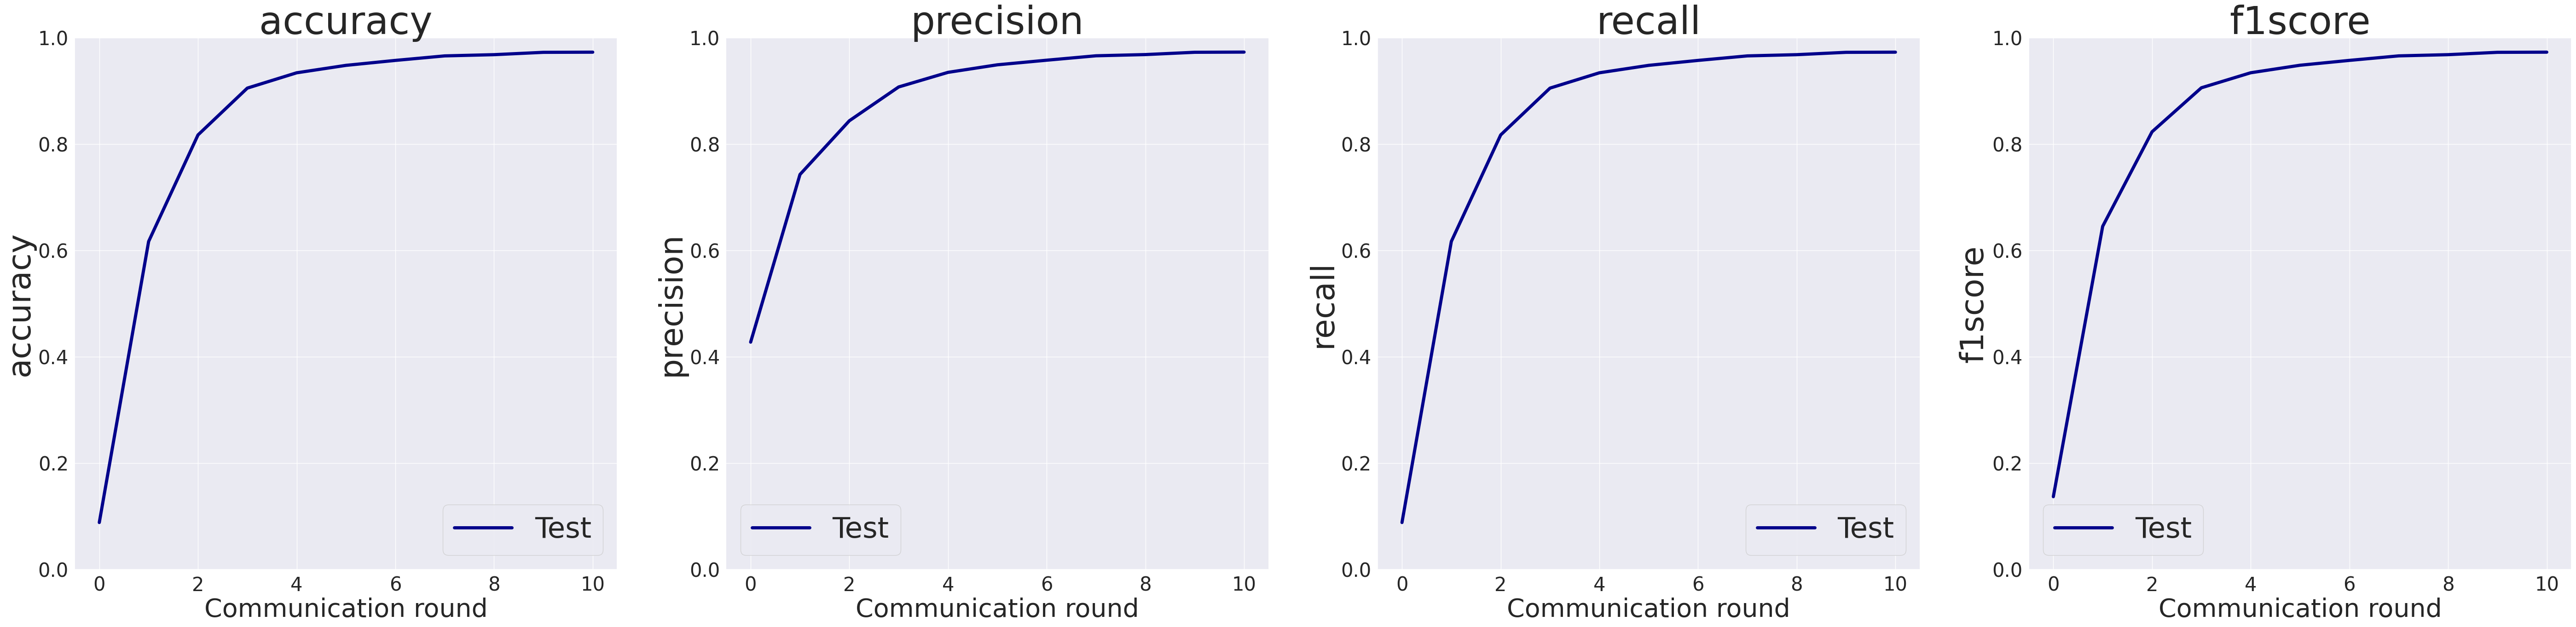

In [33]:
# Define metrics to plot
metrics_show = ["accuracy","precision","recall","f1score"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(70,15))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(commun_metrics_history,"any","centralized",metrics_show[i])

In [27]:
# Define metrics in a dataframe
metrics_DNN = {'metric_name':  ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
           'set_used': ['Test', 'Test', 'Test', 'Test'],
           'metric_value': [ global_acc_test , global_pre_test , global_rec_test , global_f1s_test]
        }

metrics_DNN = pd.DataFrame(metrics_DNN, columns = ['metric_name', 'set_used','metric_value'])

# Plot metrics
fig = go.Figure(data=[
    go.Bar(name='Test', x=metrics_DNN[metrics_DNN['set_used']=="Test"]['metric_name'], y=metrics_DNN[metrics_DNN['set_used']=="Test"]['metric_value'], marker_color=colors[4])
], layout_yaxis_range=[0,1])
# Change the bar mode
fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Metric",
    yaxis_title="Metric value",
    legend_title="Dataset", font=dict(size=20)
    )


fig.show()